## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # To visualize missing value
import plotly.graph_objects as go # To Generate Graphs
import plotly.express as px # To Generate box plot for statistical representation
%matplotlib inline

## Get data and check features

Uncomment code to print out file contents


In [ ]:
import zipfile
import requests
import os
from pathlib import Path

# Define the URL of the file you want to download
url = "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"

# Send an HTTP GET request to the URL and write into /content directory
response = requests.get(url)
fp = "/content/heart.zip"
dir = Path(os.path.dirname(fp))
with open(fp, "wb") as file: file.write(response.content)

# Extract all the contents of the ZIP file into the /content directory
with zipfile.ZipFile(fp, 'r') as zip_ref:
    zip_ref.extractall(dir)
    print(f'Contents of {fp} extracted to {dir}')

Contents of /content/heart.zip extracted to /content


In [ ]:
# with open(dir / "heart-disease.names") as f:
#     print(f.read())

Extract attribute names

In [ ]:
import re

# Define the path to the heart-disease.names file
file_path =  dir / 'heart-disease.names'

# Initialize a list to store the attribute names
input_atts = []

# Read the file and extract the attribute names using regex within the specified indices
with open(file_path, 'r') as file: lines = file.readlines()

# Use list comprehensions to find start and end indices
start_index = next((i + 1 for i, line in enumerate(lines) if line.strip() == "-- Only 14 used"), None)
end_index = next((i for i, line in enumerate(lines) if line.strip() == "-- 14. #58 (num)       (the predicted attribute)"), None)

# Extract the attribute names from the section using regex
section_text = ''.join(lines[start_index:end_index])
input_atts = re.findall(r'\((.*?)\)', section_text)

# Print the list of attribute names
print(input_atts)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


Attribute information:
1. age: The person's age in years
2.   sex: The person's sex (1 = male, 0 = female)
3. cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
4. trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
5. chol: The person's cholesterol measurement in mg/dl
6. fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
7. restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
8. thalach: The person's maximum heart rate achieved
9. exang: Exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
11. slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
12. ca: The number of major vessels (0-3)
13. thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
14. target: Heart disease (0-4, w/ 0=no, 1-3 indicating severity level)

Thdir / "heart-disease.names"e names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

## Import data

We will be importing all files containing processed data:
1. processed.cleveland.data
2. processed.hungarian.data
3. processed.switzerland.data
4. processed.va.data

In [ ]:
combined_df = pd.concat(
    (pd.read_csv(os.path.join(dir, filename), header=None)
     .assign(Location=filename.split('.')[1])
     for filename in os.listdir(dir)
     if 'processed' in filename.lower() and filename.lower().endswith('.data')),
    ignore_index=True
)
combined_df.columns = input_atts + ['target'] + ['Location']
print(combined_df.head())
print(combined_df.shape)

    age  sex   cp trestbps   chol  fbs restecg thalach exang oldpeak slope  \
0  63.0  1.0  1.0    145.0  233.0  1.0     2.0   150.0   0.0     2.3   3.0   
1  67.0  1.0  4.0    160.0  286.0  0.0     2.0   108.0   1.0     1.5   2.0   
2  67.0  1.0  4.0    120.0  229.0  0.0     2.0   129.0   1.0     2.6   2.0   
3  37.0  1.0  3.0    130.0  250.0  0.0     0.0   187.0   0.0     3.5   3.0   
4  41.0  0.0  2.0    130.0  204.0  0.0     2.0   172.0   0.0     1.4   1.0   

    ca thal  target   Location  
0  0.0  6.0     0.0  cleveland  
1  3.0  3.0     2.0  cleveland  
2  2.0  7.0     1.0  cleveland  
3  0.0  3.0     0.0  cleveland  
4  0.0  3.0     0.0  cleveland  
(1214, 15)


## Exploratory Data Analysis (EDA)

Now, according to the documentation, 4 files are labelled as processed, but the Cleveland one, save for ? entries is the cleanest. So, we can use the Cleveland one to pre-process the rest of the data in the other three files!

In [ ]:
import warnings
# To suppress all warnings:
warnings.filterwarnings("ignore")

In [ ]:
df_cl = combined_df[combined_df['Location'] == 'cleveland']
df_cl['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [ ]:
df_cl.replace('?', np.nan, inplace=True)

# Drop rows containing NaN values
df_cl.dropna(inplace=True)
df_cl.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
Location    0
dtype: int64

Now, get the range of appropriate values. We just operate on the Cleveland dataset, since the documentation notes that it is the cleanest of all processed files.

In [ ]:
column_ranges = {}

# Iterate through columns in the DataFrame
for column in df_cl.iloc[:, :-1]:
    # Calculate the range (min and max) for the column
    col_vals = sorted(df_cl[column].unique())

    # Store the enumerated range in the dictionary
    column_ranges[column] = col_vals

# Print the column name to enumerated range mappings
for column, col_range in column_ranges.items():
    print(f"{column}: {col_range}")

age: [29.0, 34.0, 35.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 74.0, 76.0, 77.0]
sex: [0.0, 1.0]
cp: [1.0, 2.0, 3.0, 4.0]
trestbps: [94.0, 100.0, 101.0, 102.0, 104.0, 105.0, 106.0, 108.0, 110.0, 112.0, 114.0, 115.0, 117.0, 118.0, 120.0, 122.0, 123.0, 124.0, 125.0, 126.0, 128.0, 129.0, 130.0, 132.0, 134.0, 135.0, 136.0, 138.0, 140.0, 142.0, 144.0, 145.0, 146.0, 148.0, 150.0, 152.0, 154.0, 155.0, 156.0, 158.0, 160.0, 164.0, 165.0, 170.0, 172.0, 174.0, 178.0, 180.0, 192.0, 200.0]
chol: [126.0, 131.0, 141.0, 149.0, 157.0, 160.0, 164.0, 166.0, 167.0, 168.0, 169.0, 172.0, 174.0, 175.0, 176.0, 177.0, 178.0, 180.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 192.0, 193.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0, 201.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.

Now, apply clean up to any of these list values that are longer than 5. Why 5? Honestly, it is bad practice to include "magic numbers" in your code. This is just so you can get an idea of the allowed values for this demo. We will do data cleaning on the rest of the dataset.

In [ ]:
for attr, values in column_ranges.items():
    # Check if the length of the list is greater than 5
    if len(values) > 5:
        # Replace the list with np.float64
        column_ranges[attr] = np.float64

# Print the modified dictionary
print(column_ranges)

{'age': <class 'numpy.int64'>, 'sex': [0.0, 1.0], 'cp': [1.0, 2.0, 3.0, 4.0], 'trestbps': <class 'numpy.int64'>, 'chol': <class 'numpy.int64'>, 'fbs': [0.0, 1.0], 'restecg': [0.0, 1.0, 2.0], 'thalach': <class 'numpy.int64'>, 'exang': [0.0, 1.0], 'oldpeak': <class 'numpy.int64'>, 'slope': [1.0, 2.0, 3.0], 'ca': ['0.0', '1.0', '2.0', '3.0'], 'thal': ['3.0', '6.0', '7.0'], 'target': [0.0, 1.0, 2.0, 3.0, 4.0]}


Let's first drop any values that are ? or NaN. Then, let's convert everything to the same data-type before we do further processing.

In [ ]:
# Drop rows containing NaN values
df = combined_df
df.dropna(inplace=True)
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

print(df.shape)
print(df.info())

(1214, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1214 non-null   object 
 1   sex       1214 non-null   float64
 2   cp        1214 non-null   float64
 3   trestbps  1214 non-null   object 
 4   chol      1214 non-null   object 
 5   fbs       1214 non-null   object 
 6   restecg   1214 non-null   object 
 7   thalach   1214 non-null   object 
 8   exang     1214 non-null   object 
 9   oldpeak   1214 non-null   object 
 10  slope     1214 non-null   object 
 11  ca        1214 non-null   object 
 12  thal      1214 non-null   object 
 13  target    1214 non-null   float64
 14  Location  1214 non-null   object 
dtypes: float64(3), object(12)
memory usage: 142.4+ KB
None
(1214, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
--

In [ ]:
# Identify the columns to convert (all columns except the last one)
columns_to_convert = df.columns[:-1]

# # Convert the selected columns to float64 dtype
df[columns_to_convert] = df[columns_to_convert].astype(float)

# Print the resulting DataFrame
print(df.dtypes)

# Drop rows containing -9.0 values
# Documentation says -9.0 is treated as NaN
df = combined_df
df.dropna(inplace=True)
df.replace('-9.0', np.nan, inplace=True)
df.dropna(inplace=True)
df.isnull().sum()
# df = df[~(df < 0).any(axis=1)]

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target      float64
Location     object
dtype: object


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
Location    0
dtype: int64

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'target'}>, <Axes: >, <Axes: >]],
      dtype=object)

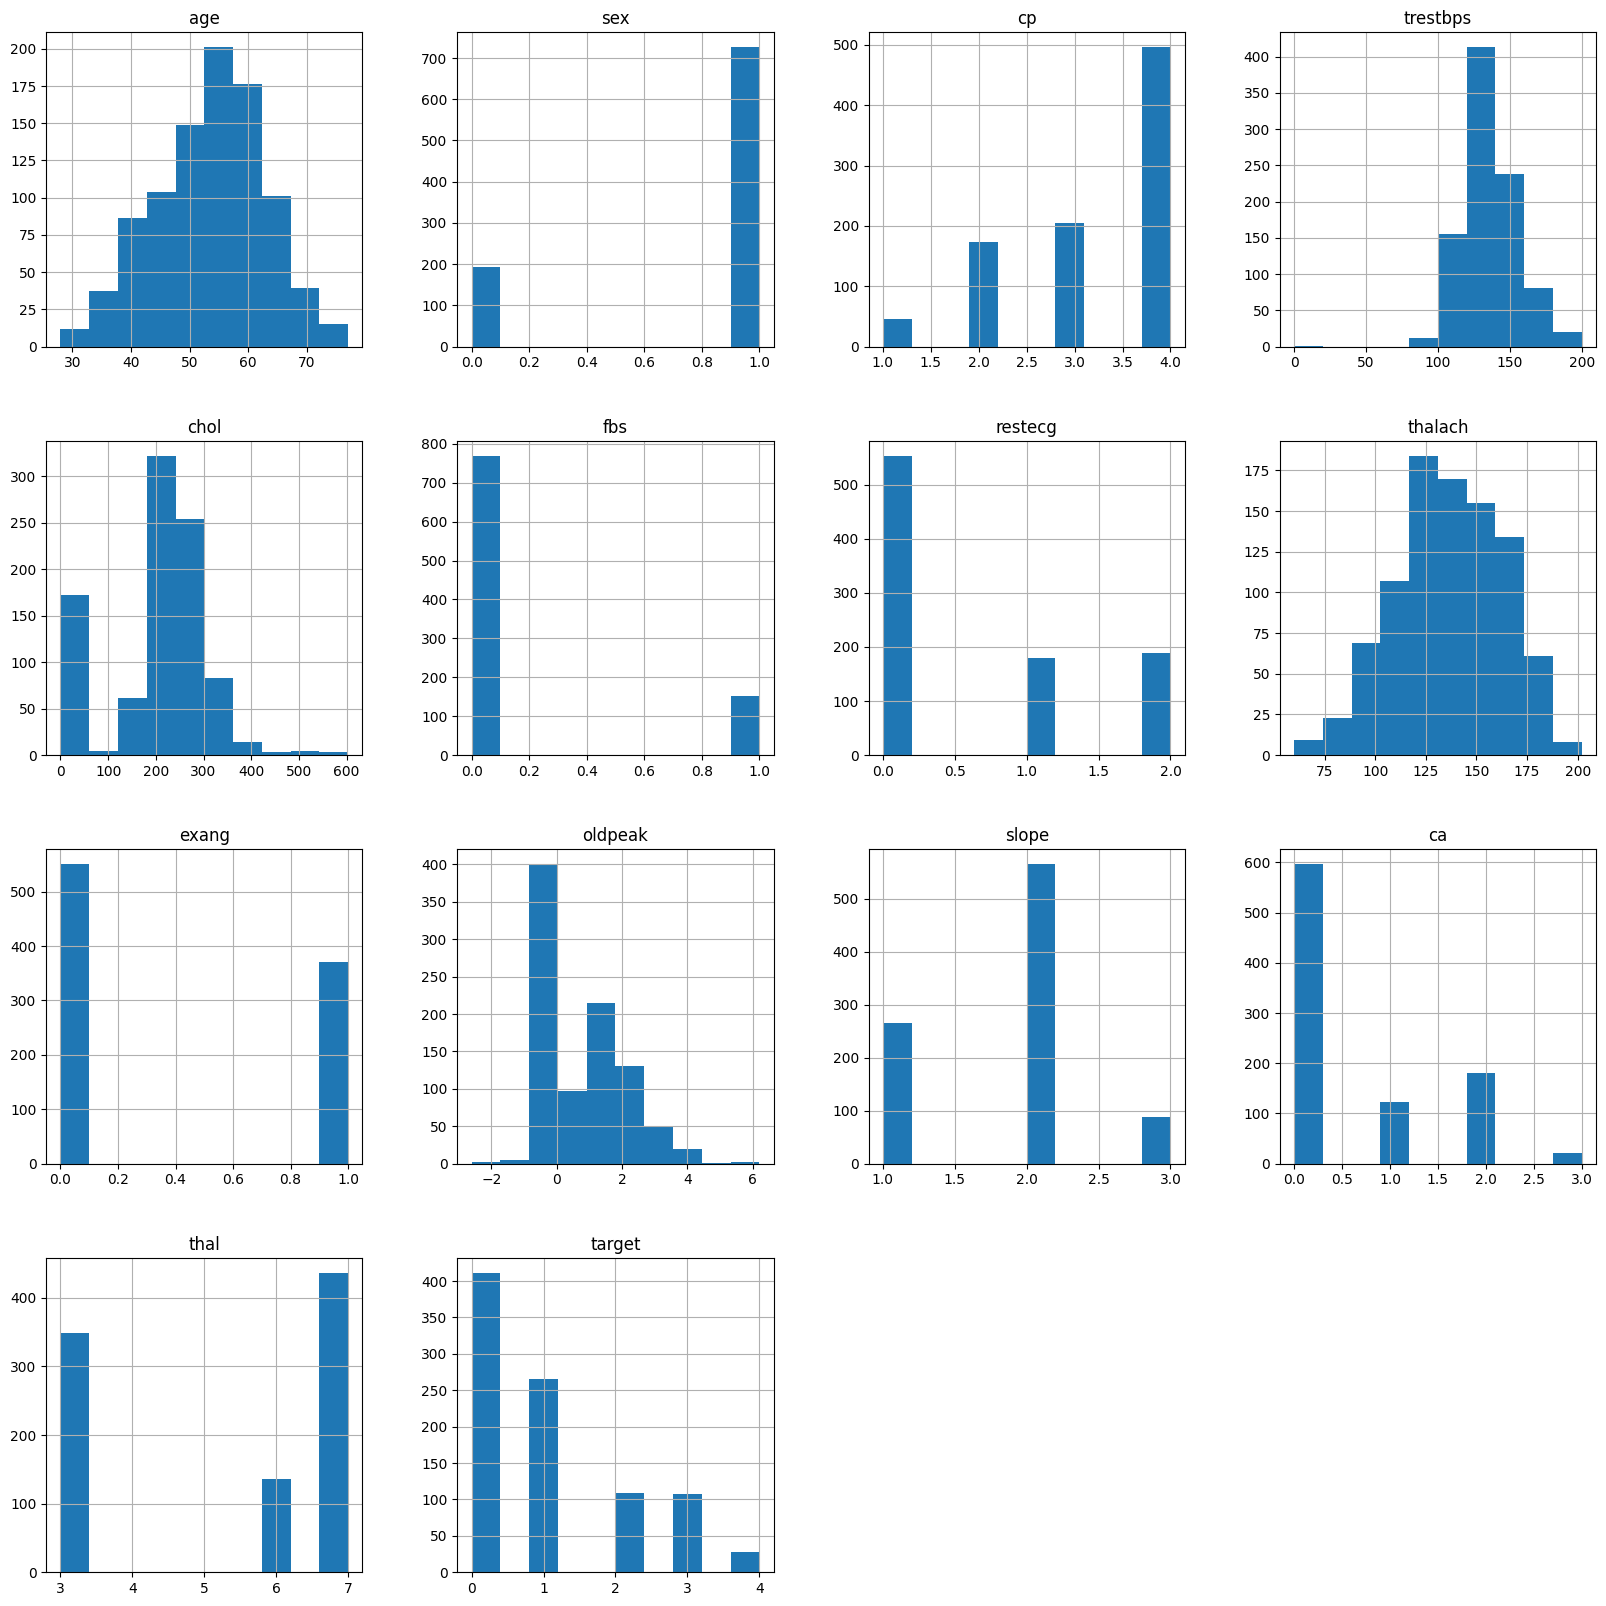

In [ ]:
float_df = df.select_dtypes(include='float64')

float_df.hist(figsize=(20,20))

<Axes: >

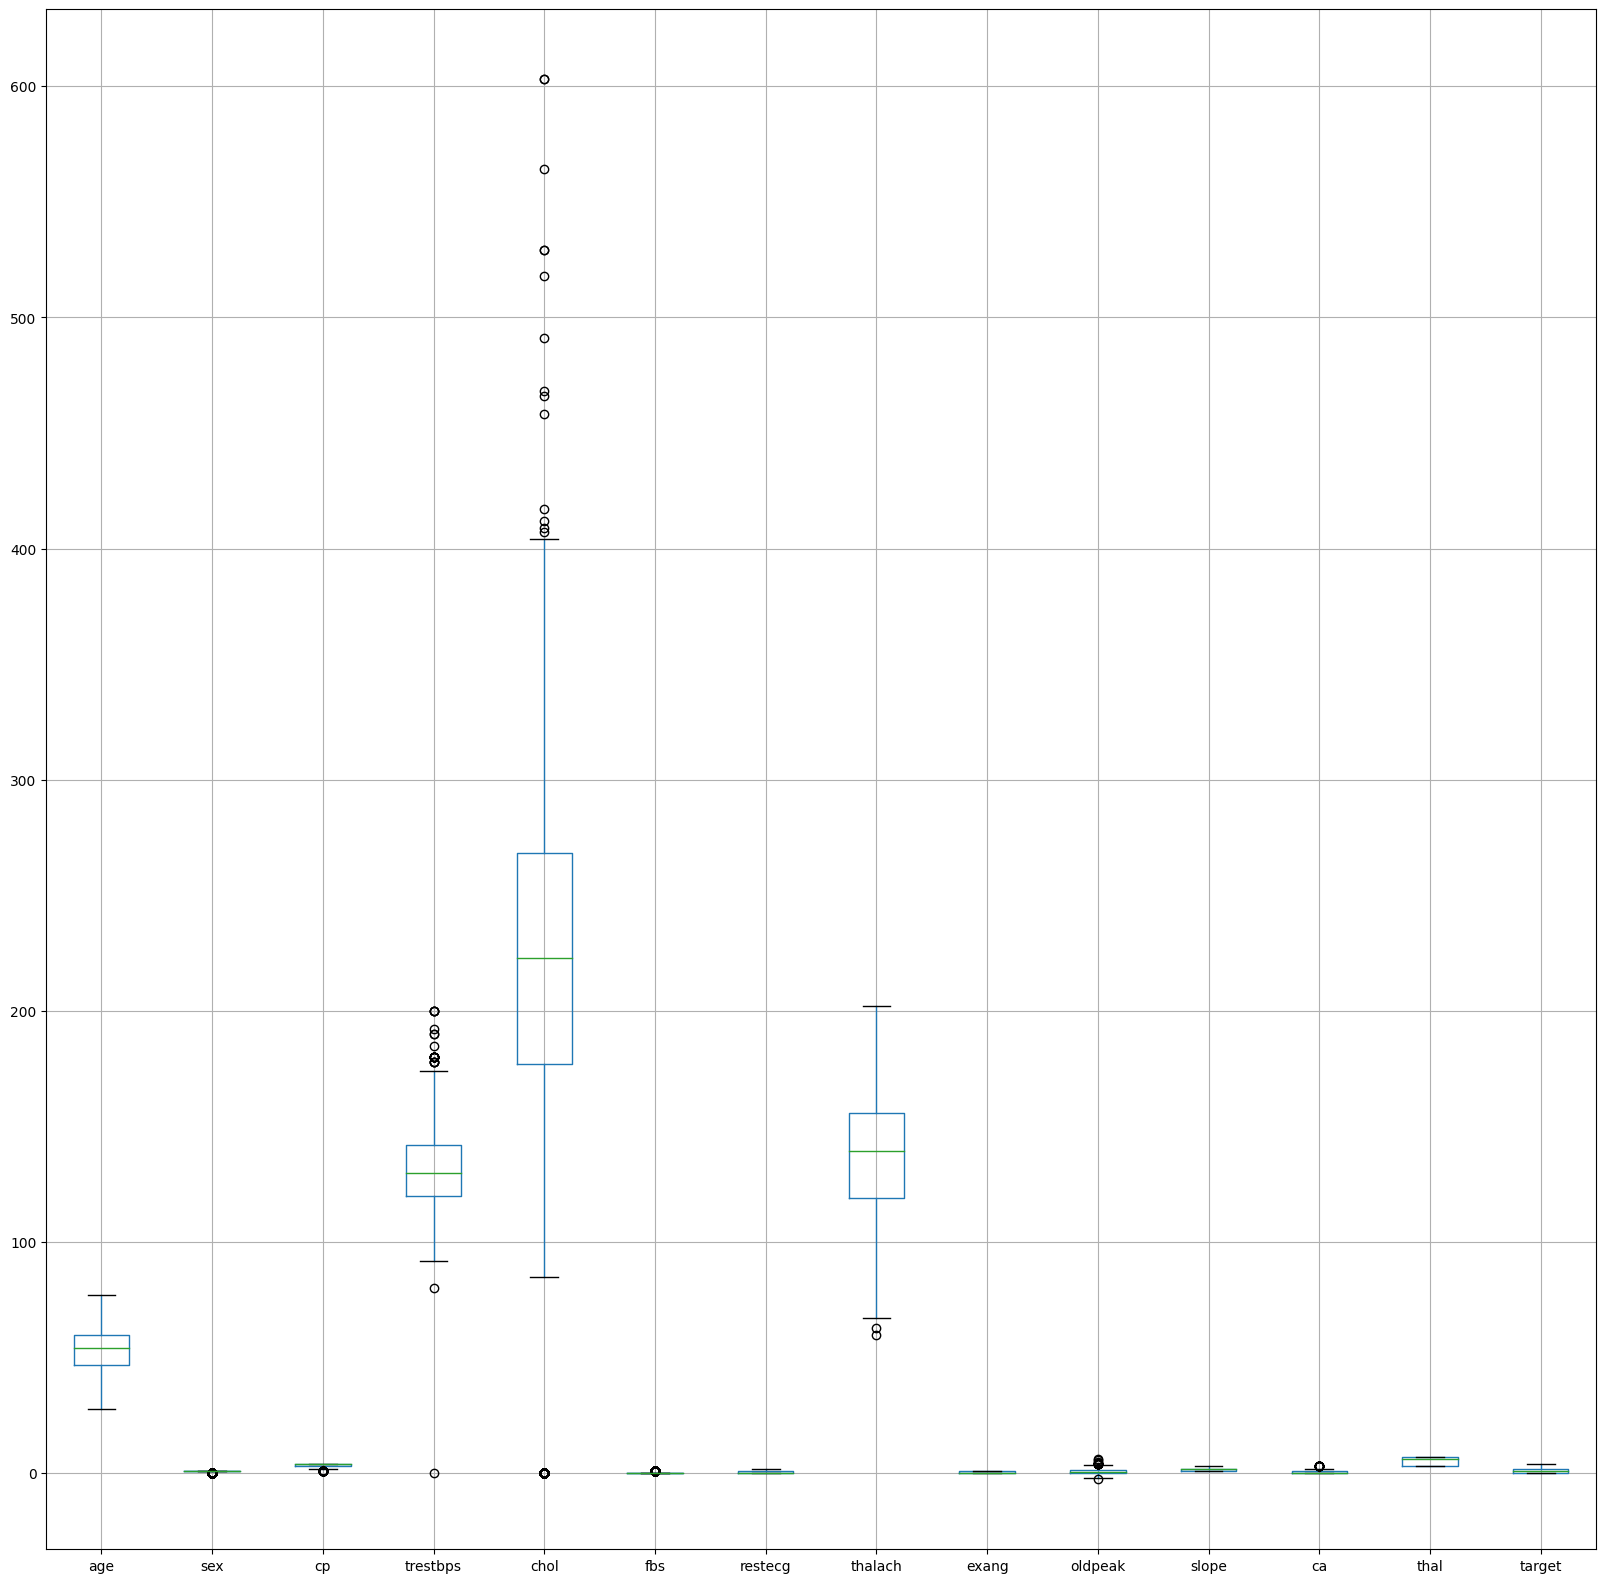

In [ ]:
float_df.boxplot(figsize=(20,20))

## Feature Selection

Play around with n to find the n best features

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Make a copy of the DataFrame
data = df.copy()

# Define the input features (X) and the target (y)
X = data.iloc[:, :-2]  # Input features (exclude the last two columns)
y = data.iloc[:, -2]   # Target variable (the second to last column)

# Create a SelectKBest instance with the chi-squared scoring function
bestfeatures = SelectKBest(score_func=chi2, k=10)

# Fit the SelectKBest model to the data
fit = bestfeatures.fit(X, y)

# Create DataFrames to store feature scores and column names
dfscores = pd.DataFrame(fit.scores_, columns=['Score'])
dfcolumns = pd.DataFrame(X.columns, columns=['Specs'])

# Concatenate the column names and scores into a single DataFrame
featureScores = pd.concat([dfcolumns, dfscores], axis=1)

# Rename the columns for clarity
featureScores.columns = ['Feature', 'Score']

# Print the top n features based on their scores
n = 5
print(featureScores.nlargest(n, 'Score'))

    Feature       Score
7   thalach  224.549138
11       ca  107.714925
9   oldpeak   98.183696
12     thal   71.296497
8     exang   39.510074


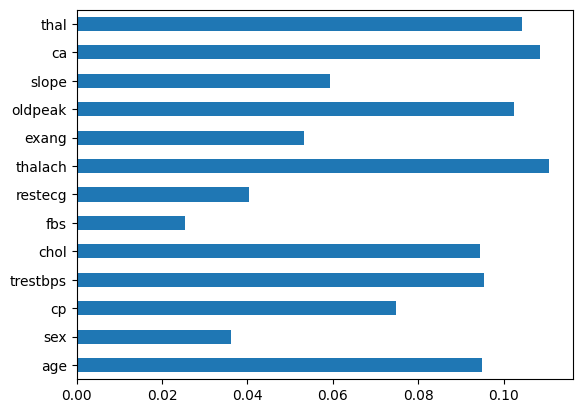

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

# Create and fit the ExtraTreesClassifier model
model = ExtraTreesClassifier()
model.fit(X, y)

# Get feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

# Plot feature importances for better visualization
feat_importances.plot(kind='barh')
plt.show()

In [ ]:
import plotly.express as px

# Replace 'df' with your DataFrame
fig = px.scatter(df, x=df['age'], y=df['target'], color=df.columns[-1])

# You can customize the title and axis labels as needed
fig.update_layout(title="Scatterplot by Location", xaxis_title="slope", yaxis_title="target")

# Show the plot
fig.show()